In [1]:
import numpy as np
from scipy.ndimage.filters import convolve, gaussian_filter
from scipy.misc import imread, imshow
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [10]:
def CannyEdgeDetector(im, blur = 1, highThreshold = 110, lowThreshold = 200):
    im = np.array(im, dtype=float) #Convert to float to prevent clipping values
 
    #Gaussian blur to reduce noise
    im2 = gaussian_filter(im, blur)
 
    #Use sobel filters to get horizontal and vertical gradients
    im3h = convolve(im2,[[-1,0,1],[-2,0,2],[-1,0,1]]) 
    im3v = convolve(im2,[[1,2,1],[0,0,0],[-1,-2,-1]])

    #Get gradient and direction
    grad = np.power(np.power(im3h, 2.0) + np.power(im3v, 2.0), 0.5)
    theta = np.arctan2(im3v, im3h)
    thetaQ = (np.round(theta * (5.0 / np.pi)) + 5) % 5 #Quantize direction
 
    #Non-maximum suppression
    gradSup = grad.copy()
    for r in range(im.shape[0]):
        for c in range(im.shape[1]):
            #Suppress pixels at the image edge
            if r == 0 or r == im.shape[0]-1 or c == 0 or c == im.shape[1] - 1:
                gradSup[r, c] = 0
                continue
            tq = thetaQ[r, c] % 4
 
            if tq == 0: #0 is E-W (horizontal)
                if grad[r, c] <= grad[r, c-1] or grad[r, c] <= grad[r, c+1]:
                    gradSup[r, c] = 0
            if tq == 1: #1 is NE-SW
                if grad[r, c] <= grad[r-1, c+1] or grad[r, c] <= grad[r+1, c-1]:
                    gradSup[r, c] = 0
            if tq == 2: #2 is N-S (vertical)
                if grad[r, c] <= grad[r-1, c] or grad[r, c] <= grad[r+1, c]:
                    gradSup[r, c] = 0
            if tq == 3: #3 is NW-SE
                if grad[r, c] <= grad[r-1, c-1] or grad[r, c] <= grad[r+1, c+1]:
                    gradSup[r, c] = 0
 
    #Double threshold
    strongEdges = (gradSup > highThreshold)
 
    #Strong has value 2, weak has value 1
    thresholdedEdges = np.array(strongEdges, dtype=np.uint8) + (gradSup > lowThreshold)
 
    #Tracing edges with hysteresis	
    #Find weak edge pixels near strong edge pixels
    finalEdges = strongEdges.copy()
    currentPixels = []
    for r in range(1, im.shape[0]-1):
        for c in range(1, im.shape[1]-1):	
            if thresholdedEdges[r, c] != 1:
                continue #Not a weak pixel
 
            #Get 3x3 patch	
            localPatch = thresholdedEdges[r-1:r+2,c-1:c+2]
            patchMax = localPatch.max()
            if patchMax == 2:
                currentPixels.append((r, c))
                finalEdges[r, c] = 1
 
    #Extend strong edges based on current pixels
    while len(currentPixels) > 0:
        newPix = []
        for r, c in currentPixels:
            for dr in range(-1, 2):
                for dc in range(-1, 2):
                    if dr == 0 and dc == 0: continue
                    r2 = r+dr
                    c2 = c+dc
                    if thresholdedEdges[r2, c2] == 1 and finalEdges[r2, c2] == 0:
                        #Copy this weak pixel to final result
                        newPix.append((r2, c2))
                        finalEdges[r2, c2] = 1
        currentPixels = newPix
 
    return finalEdges

C:\Users\prajiet\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


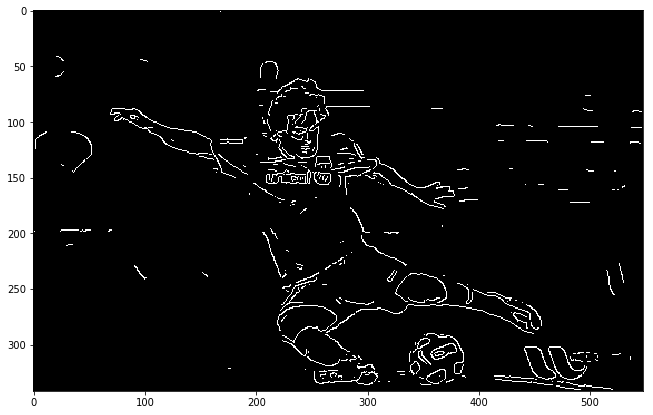

In [11]:
im = imread("messi.jpg", mode="L") #Open image, convert to greyscale
finalEdges = CannyEdgeDetector(im)
edges = cv2.Canny(im,100,200)
plt.figure(figsize=(25,7))
plt.imshow(finalEdges,cmap='gray')